### Import thư viện

In [286]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import cv2

In [287]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [288]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.utils import use_named_args

### Đọc dữ liệu

In [289]:
# đọc tên các lớp :  có 9 loại
DIR = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
# DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [290]:
data = []
path = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
# path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100,100))
        data.append([img, folder])

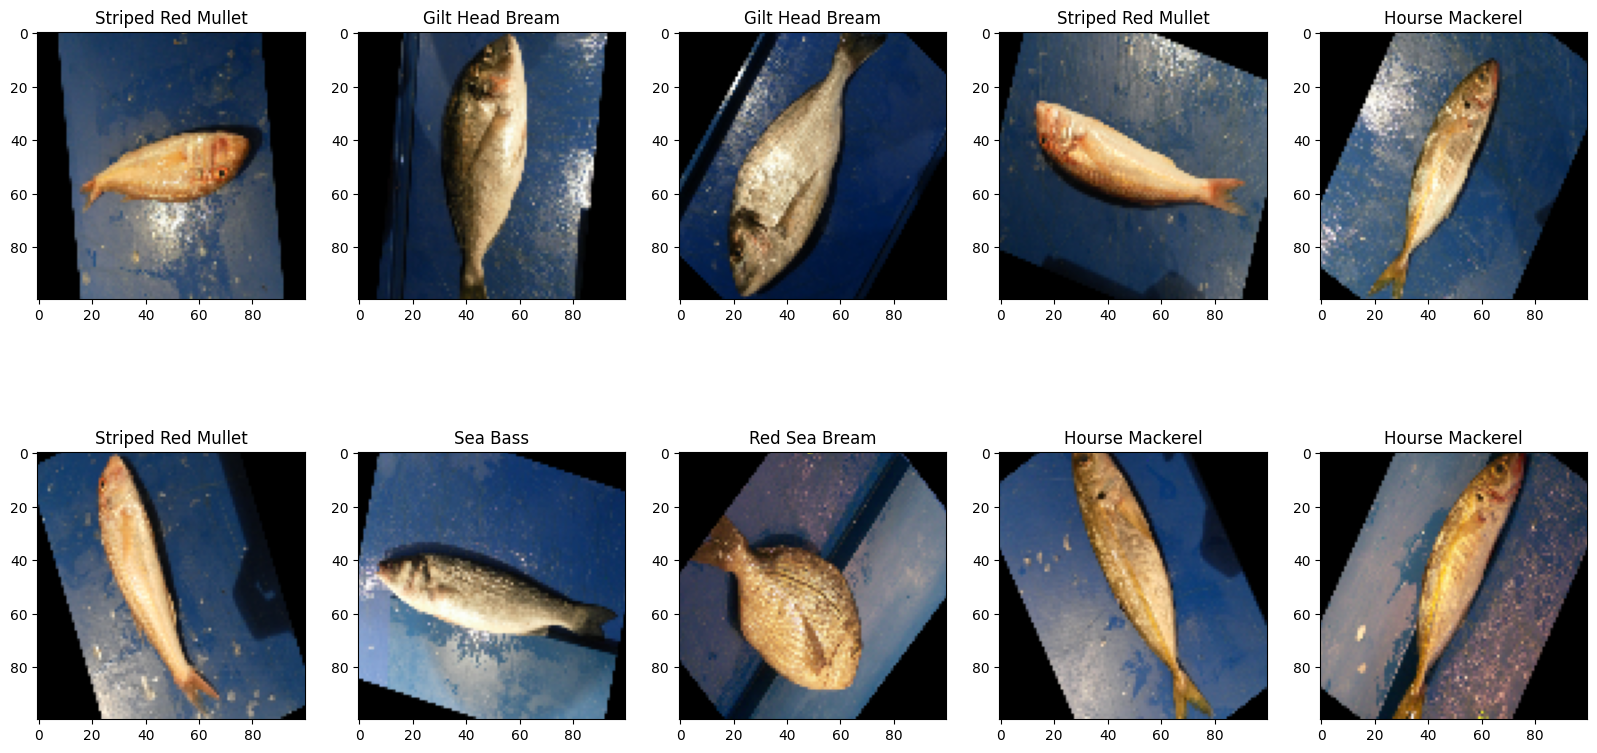

In [291]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [292]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [293]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [294]:
# chuẩn hóa label thành one-hot vector
# from keras.utils import np_utils
# labels = np_utils.to_categorical(labels, 9)
# labels
labels = tf.keras.utils.to_categorical(labels, num_classes=9)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [296]:
# reshape images
images = np.array(images)
# images = images.reshape(images.shape[0], 150, 150, 3)
images = images.reshape(images.shape[0], 100,100, 3)
images.shape

(9000, 100, 100, 3)

In [297]:
# chuẩn hóa images
images = images.astype('float32') / 255.0

### Chia dữ liệu Train và Validation

In [298]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=1000, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((8000, 100, 100, 3), (1000, 100, 100, 3), (8000, 9), (1000, 9))

In [299]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 889, 1: 889, 2: 889, 3: 889, 4: 889, 5: 889, 6: 888, 7: 889, 8: 889}

### Xây dựng model

In [300]:
h = train_images.shape[1]
w = train_images.shape[2]
c = train_images.shape[3]

In [303]:
# model = Sequential()

# model.add(Conv2D(kernel_size=4, strides=4, filters=32, padding="same", activation='relu', name="layer_conv1", input_shape=(h,w,c)))
# model.add(MaxPool2D(pool_size=2, strides=2))
# model.add(BatchNormalization())

# model.add(Conv2D(kernel_size=2, strides=2, filters=64, padding="same", activation='relu', name="layer_conv2"))
# model.add(MaxPool2D(pool_size=2, strides=2))
# model.add(BatchNormalization())

# model.add(Conv2D(kernel_size=2, strides=1, filters=128, padding="same", activation='relu', name="layer_conv3"))
# model.add(MaxPool2D(pool_size=2, strides=2))

# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128,activation='relu'))
# model.add(Dense(9, activation="softmax"))

# optimizer = Adam()
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(h,w,c)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [304]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 49, 49, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 49, 49, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 64)      

In [305]:
history = model.fit(train_images ,train_labels, batch_size=32, epochs=15, verbose=1, validation_data=(val_images, val_labels))

Epoch 1/15
250/250 [==============================] - 99s 385ms/step - loss: 0.9921 - accuracy: 0.6854 - val_loss: 6.7586 - val_accuracy: 0.1120
Epoch 2/15
250/250 [==============================] - 96s 383ms/step - loss: 0.2744 - accuracy: 0.9094 - val_loss: 4.5516 - val_accuracy: 0.3490
Epoch 3/15
250/250 [==============================] - 94s 375ms/step - loss: 0.1405 - accuracy: 0.9599 - val_loss: 0.8460 - val_accuracy: 0.7170
Epoch 4/15
250/250 [==============================] - 94s 376ms/step - loss: 0.0912 - accuracy: 0.9737 - val_loss: 0.4523 - val_accuracy: 0.8240
Epoch 5/15
250/250 [==============================] - 85s 339ms/step - loss: 0.0795 - accuracy: 0.9707 - val_loss: 0.2502 - val_accuracy: 0.9010
Epoch 6/15
250/250 [==============================] - 80s 321ms/step - loss: 0.0608 - accuracy: 0.9811 - val_loss: 0.0403 - val_accuracy: 0.9870
Epoch 7/15
250/250 [==============================] - 80s 319ms/step - loss: 0.0546 - accuracy: 0.9820 - val_loss: 0.9862 - val_ac

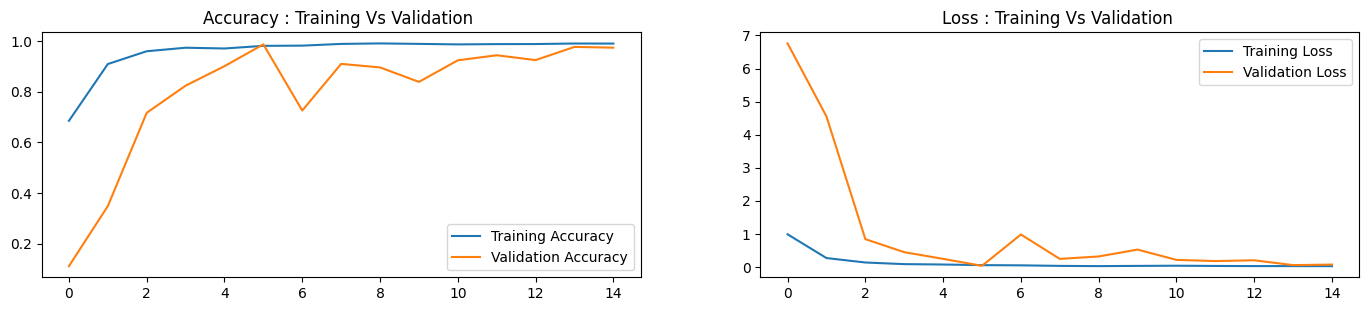

In [307]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(15), accuracy, label='Training Accuracy')
plt.plot(range(15), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(15), loss, label='Training Loss')
plt.plot(range(15), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show();

In [308]:
# Evaluating the model
score = model.evaluate(val_images, val_labels, verbose=0)
print('val loss:', score[0])
print('Val accuracy:', score[1]*100,"%")

val loss: 0.07742176949977875
Val accuracy: 97.39999771118164 %


In [309]:
val_pre = model.predict(val_images)


32/32 [==============================] - 2s 61ms/step


In [310]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(val_labels.argmax(axis=1), val_pre.argmax(axis=1), target_names=classes));

                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      0.97      0.98       111
   Gilt Head Bream       1.00      1.00      1.00       111
   Hourse Mackerel       0.99      1.00      1.00       111
        Red Mullet       1.00      1.00      1.00       111
     Red Sea Bream       0.98      1.00      0.99       111
          Sea Bass       0.97      1.00      0.99       111
            Shrimp       1.00      0.82      0.90       112
Striped Red Mullet       0.85      0.97      0.91       111
             Trout       1.00      1.00      1.00       111

          accuracy                           0.97      1000
         macro avg       0.98      0.97      0.97      1000
      weighted avg       0.98      0.97      0.97      1000



Xem test


In [311]:
# đọc tên các lớp :  có 9 loại
DIR_TEST = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset' 
# DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes_test = [i for i in os.listdir(DIR_TEST) if '.' not in i]                     
classes_test

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [ ]:
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset\\Gilt Head Bream\\00003.png'
img = cv2.imread(path)
height, width, channels = img.shape
print('Chiều cao:', height)
print('Chiều rộng:', width)
print('Số kênh màu:', channels)

path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset\\Black Sea Sprat\\00001.png'
img = cv2.imread(path)
height, width, channels = img.shape
print('Chiều cao:', height)
print('Chiều rộng:', width)
print('Số kênh màu:', channels)

Chiều cao: 2128
Chiều rộng: 2832
Số kênh màu: 3
Chiều cao: 768
Chiều rộng: 1024
Số kênh màu: 3


In [313]:
data_test = []
# path = "D:\\study\\machine_learning\\classification_fish\\data\\NA_Fish_Dataset"
path = 'D:\\study-hk2\\ML\\ML\\classification_fish\\data\\NA_Fish_Dataset'
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder)
    num_images = len(os.listdir(folder_path))  # Đếm số lượng ảnh trong thư mục
    for i in range(1, num_images + 1):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100,100))
        data_test.append([img, folder])


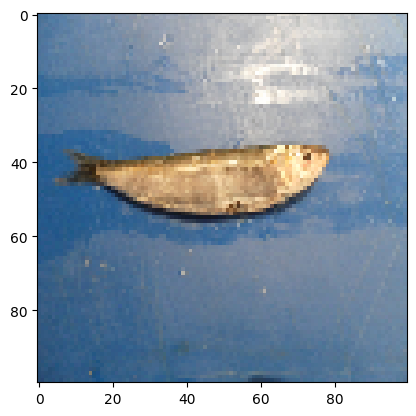

(100, 100, 3)


In [314]:
im = data_test[0][0]
plt.imshow(im)
plt.show()
print(im.shape)

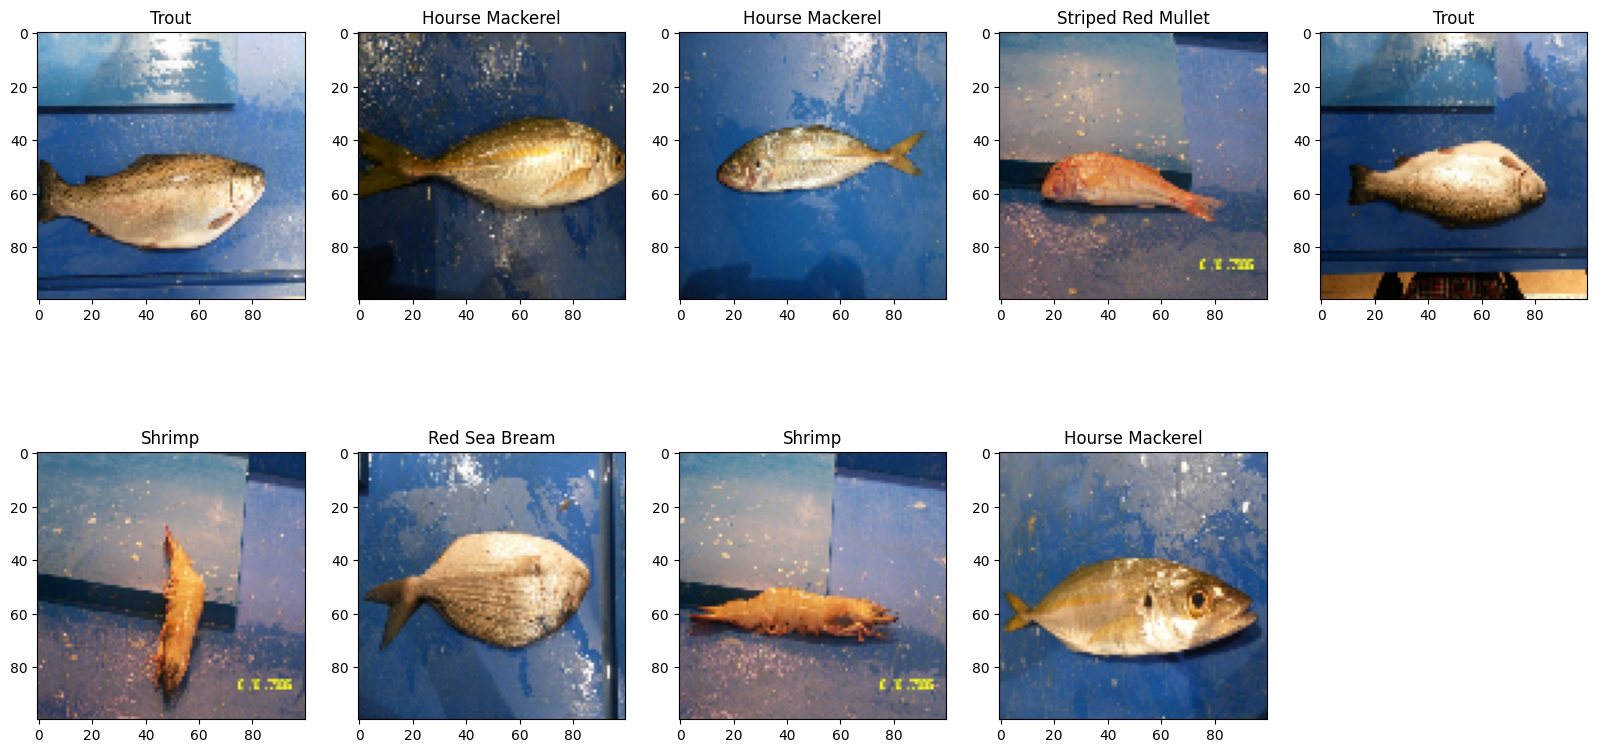

In [315]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(9):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 429)
    plt.imshow(data_test[j+i][0])
    plt.title(data_test[j+i][1])

In [318]:
# shuffle data_test
import random
random.shuffle(data_test)

In [319]:
# tạo image và label từ data_test
test_images = []
test_labels = []
for image, label in data_test:
    test_images.append(image)
    test_labels.append(label)

In [320]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
test_labels = le.fit_transform(test_labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [321]:
# chuẩn hóa label thành one-hot vector
# from keras.utils import np_utils
# test_labels = np_utils.to_categorical(test_labels, 9)
# test_labels

test_labels  = tf.keras.utils.to_categorical(test_labels , num_classes=9)
test_labels 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [322]:
# reshape images
test_images = np.array(test_images)
# images = images.reshape(images.shape[0], 150, 150, 3)
test_images = test_images.reshape(test_images.shape[0], 100,100, 3)
test_images.shape

(430, 100, 100, 3)

In [324]:
test_images.shape, test_labels.shape

((430, 100, 100, 3), (430, 9))

In [323]:
# chuẩn hóa images
test_images = test_images.astype('float32') / 255.0

In [325]:
test_pre = model.predict(test_images)

14/14 [==============================] - 1s 62ms/step


In [328]:
# Evaluating the model
score = model.evaluate(test_images,test_labels,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100,"%")

Test loss: 0.9224498867988586
Test accuracy: 73.72093200683594 %


In [330]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels.argmax(axis=1), test_pre.argmax(axis=1), target_names=classes_test));

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.84      0.91        50
   Gilt Head Bream       0.50      1.00      0.67        50
   Hourse Mackerel       0.71      0.10      0.18        50
        Red Mullet       1.00      1.00      1.00        50
     Red Sea Bream       0.97      0.78      0.87        50
          Sea Bass       0.57      0.98      0.72        50
            Shrimp       1.00      0.42      0.59        50
Striped Red Mullet       0.64      0.82      0.72        50
             Trout       1.00      0.67      0.80        30

          accuracy                           0.74       430
         macro avg       0.82      0.73      0.72       430
      weighted avg       0.81      0.74      0.71       430



In [ ]:
hhe

In [ ]:
def create_cnn(learning_rate, num_dense_layers, num_dense_nodes, activation, dropout_rate):
    model = Sequential()

    model.add(Conv2D(kernel_size=4, strides=4, filters=32, padding="same", activation=activation, name="layer_conv1"))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(BatchNormalization())

    model.add(Conv2D(kernel_size=2, strides=2, filters=64, padding="same", activation=activation, name="layer_conv2"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(kernel_size=2, strides=1, filters=128, padding="same", activation=activation, name="layer_conv3"))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten())

    for i in range(num_dense_layers):
        name = f"layer_dense_{i+1}"
        model.add(Dense(num_dense_nodes, activation=activation, name=name))
        model.add()
        model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(9, activation="softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# xác định các hyperparameter
dim_learning_rate = Real(low=1e-6, high=1e-2, prior="log-uniform", name="learning_rate")
dim_num_dense_layers = Integer(low=1, high=5, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=512, name="num_dense_nodes")
dim_activation = Categorical(categories=["relu", "sigmoid"], name="activation")
dim_dropout_rate = Real(low=0.2, high=0.5, prior="log-uniform", name="dropout_rate")

In [ ]:
param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
    dim_dropout_rate
]

In [ ]:
path_best_model = "cnn_model.h5"
best_accuracy = 0.0

In [ ]:
@use_named_args(param_grid)
def objective(learning_rate, num_dense_layers, num_dense_nodes,activation, dropout_rate):
    print("learning rate: {0:.1e}".format(learning_rate))
    print("num_dense_layers:", num_dense_layers)
    print("num_dense_nodes:", num_dense_nodes)
    print("activation:", activation)
    print()

    model = create_cnn(learning_rate=learning_rate,
                          num_dense_layers=num_dense_layers,
                            num_dense_nodes=num_dense_nodes,
                            activation=activation, dropout_rate=dropout_rate)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)
    history = model.fit(x=train_images,y=train_labels,epochs=10,batch_size=64,validation_split=0.1,callbacks=[learning_rate_reduction])

    accuracy = history.history['val_accuracy'][-1]

    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy
    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model

    return -accuracy

##### Các hyperparameter mặc định

In [ ]:
# default_parameters = [1e-5, 1, 16, "relu", 0.2]
default_parameters = [1e-5, 1, 16, "relu", 0.2]
objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/10
114/114 [==============================] - 86s 748ms/step - loss: 2.1897 - accuracy: 0.1278 - val_loss: 2.1760 - val_accuracy: 0.1938 - lr: 1.0000e-05
Epoch 2/10
114/114 [==============================] - 94s 827ms/step - loss: 2.1628 - accuracy: 0.1635 - val_loss: 2.1405 - val_accuracy: 0.1667 - lr: 1.0000e-05
Epoch 3/10
114/114 [==============================] - 98s 863ms/step - loss: 2.1194 - accuracy: 0.1933 - val_loss: 2.0889 - val_accuracy: 0.1840 - lr: 1.0000e-05
Epoch 4/10
114/114 [==============================] - 107s 936ms/step - loss: 2.0677 - accuracy: 0.2289 - val_loss: 2.0230 - val_accuracy: 0.2494 - lr: 1.0000e-05
Epoch 5/10
114/114 [==============================] - 113s 994ms/step - loss: 2.0038 - accuracy: 0.2646 - val_loss: 1.9510 - val_accuracy: 0.3272 - lr: 1.0000e-05
Epoch 6/10
114/114 [==============================] - 116s 1s/step - loss: 1.9350 - accuracy: 0.3064 - val_

-0.480246901512146

In [ ]:
gp_ = gp_minimize(func=objective,
                    dimensions=param_grid,
                    x0 = default_parameters,
                    acq_func="EI",
                    n_calls=30,
                    random_state=0)

##### Best model

In [ ]:
"Best score=%.4f" % gp_.fun

In [ ]:
print("""Best parameters:
=========================
- learning_rate=%.6f
- num_dense_layers=%d
- num_dense_nodes=%d
- activation=%s""" % (gp_.x[0], gp_.x[1], gp_.x[2], gp_.x[3]))

In [ ]:
plot_convergence(gp_)

In [ ]:
dim_names = ["learning_rate", "num_dense_layers", "num_dense_nodes", "activation"]

In [ ]:
plot_objective(result=gp_, dimensions=dim_names)
plt.show()

In [ ]:
plot_evaluations(result=gp_, dimensions=dim_names)
plt.show()

##### Evaluate the model

In [ ]:
model = load_model(path_best_model)

In [ ]:
result = model.evaluate(x=val_images,y=val_labels)

29/29 [==============================] - 2s 64ms/step - loss: 1.6210 - accuracy: 0.4889


In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 1.621006727218628
accuracy 0.4888888895511627


In [ ]:
y_pred = model.predict(x=val_images)

y_pred_classes = np.argmax(y_pred,axis=1)

y_true = np.argmax(val_labels,axis=1)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_classes)

29/29 [==============================] - 3s 118ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

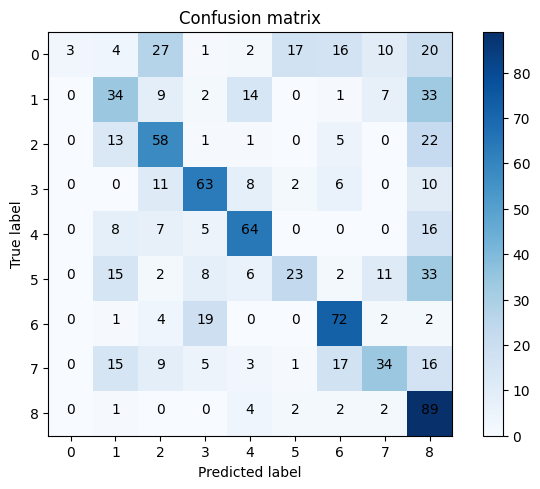

In [ ]:
classes = 9

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes))
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(classes), range(classes)):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > 100 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# tính accuracy, recall, precision
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred_classes)
recall = recall_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")
precision = precision_score(y_true=y_true, y_pred=y_pred_classes, average="weighted")

print("Accuracy: {0:.2%}, Recall: {1:.2%}, Precision: {2:.2%}".format(accuracy, recall, precision))

Accuracy: 48.89%, Recall: 48.89%, Precision: 56.16%
